In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import torch.nn as nn 
import torch.optim as optim 
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch

import torchvision

In [2]:
IMG_FOLDER = "data"

### hyperparameters

In [3]:
batch_size = 128 
learning_rate = 0.0002
beta_momentum = 0.5
gen_out_shape = 64
epochs = 10

In [4]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("device : ", device)

device :  cuda


In [5]:
transform = transforms.Compose([
    transforms.Resize(gen_out_shape),
    transforms.CenterCrop(gen_out_shape),
    transforms.ToTensor(), 
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

data_loader = datasets.ImageFolder(IMG_FOLDER,transform=transform)
print("dataset size : ", len(data_loader))

dataset size :  135610


In [6]:
data_loader = torch.utils.data.DataLoader(data_loader,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          num_workers=2,
                                          drop_last=True
                                         )

In [7]:
len(data_loader)

1059

In [8]:
data = iter(data_loader)
images, label = data.next()

In [9]:
print(label)
grid = torchvision.utils.make_grid(images[:30], normalize=True, padding=2)

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])


In [10]:
def plot_image(inp, title=None): 
    plt.figure(figsize=(10,10))
    inp = np.transpose(inp, axes=[1, 2, 0])
    plt.title(title)
    plt.imshow(inp)
    return

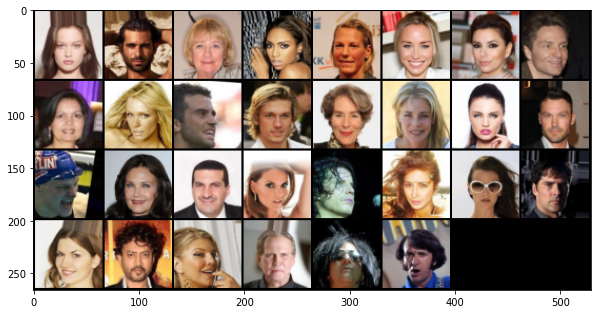

In [11]:
plot_image(grid)

In [12]:
def custom_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [13]:
import torch.nn.functional as F_

class Generator(nn.Module): 
    
    def __init__(self, ns, output_size): 
        super(Generator, self).__init__()
        self.ns = ns 
        self.output_size = output_size
        self.upconv1 = nn.ConvTranspose2d(ns, 512, 4, bias=False)
        self.bn1 = nn.BatchNorm2d(512)
        self.upconv2 = nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False)
        self.bn2 = nn.BatchNorm2d(256)
        self.upconv3 = nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False)
        self.bn3 = nn.BatchNorm2d(128)
        self.upconv4 = nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False)
        self.bn4 = nn.BatchNorm2d(64)
        self.upconv5 = nn.ConvTranspose2d(64, 3, 4, 2, 1, bias=False)
    
    def forward(self, x): 
        x = F_.relu(self.bn1(self.upconv1(x)))
        x = F_.relu(self.bn2(self.upconv2(x)))
        x = F_.relu(self.bn3(self.upconv3(x)))
        x = F_.relu(self.bn4(self.upconv4(x)))
        x = self.upconv5(x)
        x = torch.tanh(x)
        
        return x

In [14]:
# summary 
from torchsummary import summary

generator = Generator(100, gen_out_shape)
generator.to(device)
summary(generator, input_size=(100,1, 1), batch_size=1, device="cuda")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1             [1, 512, 4, 4]         819,200
       BatchNorm2d-2             [1, 512, 4, 4]           1,024
   ConvTranspose2d-3             [1, 256, 8, 8]       2,097,152
       BatchNorm2d-4             [1, 256, 8, 8]             512
   ConvTranspose2d-5           [1, 128, 16, 16]         524,288
       BatchNorm2d-6           [1, 128, 16, 16]             256
   ConvTranspose2d-7            [1, 64, 32, 32]         131,072
       BatchNorm2d-8            [1, 64, 32, 32]             128
   ConvTranspose2d-9             [1, 3, 64, 64]           3,072
Total params: 3,576,704
Trainable params: 3,576,704
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 1.97
Params size (MB): 13.64
Estimated Total Size (MB): 15.61
-------------------------------------

In [15]:

class Discriminator(nn.Module): 
    
    def __init__(self, input_size): 
        super(Discriminator, self).__init__()
        self.input_size = input_size 
        self.conv1 = nn.Conv2d(3, 64, 4, 2, 1)
        self.conv2 = nn.Conv2d(64, 128, 4, 2, 1)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 256, 4, 2, 1)
        self.bn3 = nn.BatchNorm2d(256)
        self.conv4 = nn.Conv2d(256, 512, 4, 2, 1)
        self.bn4 = nn.BatchNorm2d(512)
        
        self.fc = nn.Linear(512*4*4, 1)
        
    def forward(self, x): 
        x = F_.leaky_relu(self.conv1(x), 0.2)
        x = F_.leaky_relu(self.bn2(self.conv2(x)), 0.2)
        x = F_.leaky_relu(self.bn3(self.conv3(x)), 0.2)
        x = torch.sigmoid(self.bn4(self.conv4(x)))
        x = x.view(-1, x.shape[1] * x.shape[2] * x.shape[3])
        x = self.fc(x)
        x = torch.sigmoid(x)
        return x

In [16]:
# summary 

discriminator = Discriminator(gen_out_shape)
discriminator.to(device)
summary(discriminator, input_size=(3,gen_out_shape, gen_out_shape), batch_size=1, device="cuda")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [1, 64, 32, 32]           3,136
            Conv2d-2           [1, 128, 16, 16]         131,200
       BatchNorm2d-3           [1, 128, 16, 16]             256
            Conv2d-4             [1, 256, 8, 8]         524,544
       BatchNorm2d-5             [1, 256, 8, 8]             512
            Conv2d-6             [1, 512, 4, 4]       2,097,664
       BatchNorm2d-7             [1, 512, 4, 4]           1,024
            Linear-8                     [1, 1]           8,193
Total params: 2,766,529
Trainable params: 2,766,529
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.05
Forward/backward pass size (MB): 1.38
Params size (MB): 10.55
Estimated Total Size (MB): 11.98
----------------------------------------------------------------


### Optimization

In [17]:
g_optim = torch.optim.Adam(generator.parameters(), lr=learning_rate, betas=(beta_momentum, 0.99))
d_optim = torch.optim.Adam(discriminator.parameters(), lr=learning_rate, betas=(beta_momentum, 0.99))
criterion = nn.BCELoss()


### Training loop

In [18]:
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter('runs/dcgan_weight_init')

writer.add_graph(discriminator, images.to(device))
writer.add_graph(generator, torch.randn(128, 100, 1, 1, device="cuda"))


In [19]:
# apply weight init 

discriminator.apply(custom_init)
generator.apply(custom_init)

fixed_noise = torch.randn(batch_size, 100, 1, 1, device=device)

EPOCH : 0 | BATCH : 1/1059 | G LOSS : 1.0428199768066406 | D LOSS : 1.3870718479156494


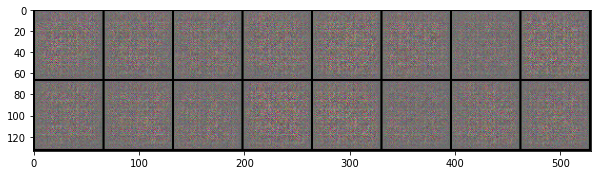

EPOCH : 0 | BATCH : 31/1059 | G LOSS : 0.8149713277816772 | D LOSS : 1.1636052131652832


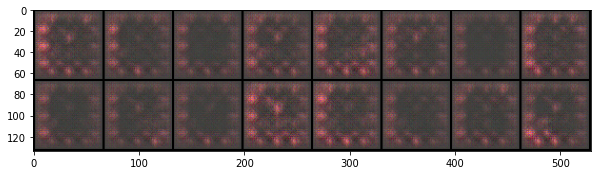

EPOCH : 0 | BATCH : 61/1059 | G LOSS : 0.9270930290222168 | D LOSS : 1.0308877229690552


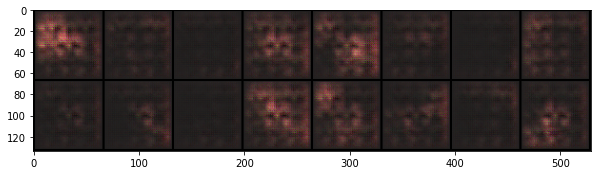

In [ ]:
for epoch in range(epochs): 
    for i, pdata in enumerate(data_loader): 
        
        discriminator.zero_grad()
        # classify true labels 
        inputs, _ = pdata 
        inputs = inputs.to(device) # gpu
        
        true_label = torch.full((batch_size,1), 1.0, dtype=torch.float32, device=device) 
        d_out = discriminator(inputs) 
        # compute loss d loss
        true_loss = criterion(d_out, true_label) 
        # compute grad 
        true_loss.backward() 
        
        # same but with generated images now 
        noise = torch.randn(batch_size, 100, 1, 1).to(device)
        fake_labels = true_label.fill_(0.0)
        g_out = generator(noise)
        dg_out = discriminator(g_out.detach())
        # compute loss again 
        fake_loss = criterion(dg_out, fake_labels)
        
        # compute grad 
        fake_loss.backward() # IMPORTANT : .backward on the same loss accumulate the function by addition
        d_loss = fake_loss + true_loss
        # update D model 
        d_optim.step() 
        
        # training the generator <=> max log(D(G(x))) <=> we use y = 1 
        generator.zero_grad()
        dgx = discriminator(g_out) 
        true_label = fake_labels.fill_(1.0) 
        # compute loss 
        g_loss = criterion(dgx, true_label) 
        # compute gradient
        g_loss.backward()
        # update G model 
        g_optim.step()
        
                
        if i % 30 == 0: 
            writer.add_scalar('discriminator_loss',
                            d_loss / 30,
                            epoch * len(data_loader) + i)
            
            writer.add_scalar('generator_loss',
                            g_loss / 30,
                            epoch * len(data_loader) + i)

            print(f"EPOCH : {epoch} | BATCH : {i+1}/{len(data_loader)} | G LOSS : {g_loss} | D LOSS : {d_loss}")
            with torch.no_grad(): 
                gen_images = generator(fixed_noise).cpu()
                to_plot = torchvision.utils.make_grid(gen_images[:16], normalize=True, padding=2)
                plot_image(to_plot)
                plt.show()
            

In [ ]:
noise = torch.randn(1, 100, 1, 1, device=device) 
out = generator(noise) 
print(out.shape)
plt.imshow(np.transpose(out.detach().cpu()*255.0, (0, 2, 3, 1))[0])